In [1]:
using Pkg
Pkg.activate("../")
include("../smc/smc.jl")
include("../smc/models/model_noisyor_final.jl")
using JSON3
using JSON
using Plots
using VegaLite
using Serialization: deserialize
using Compose: set_default_graphic_size, cm
using DataFrames
using Statistics: cor, std

  Activating project at `~/Projects/risk-aversive-exploration`
  Activating project at `~/Projects/risk-aversive-exploration/jupyter`
[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]


# Path to ABCSMC Fits

In [2]:
data_folder = "../fit_results/abcsmc_final/"

"../fit_results/abcsmc_final/"

In [3]:
timid_animals = Set([18, 13, 8, 25, 21, 9, 4, 2, 15])
intermediate_animals = Set([10, 11, 24, 17, 1, 6])
confident_animals = Set([5, 16, 20, 12, 19, 0, 22, 23, 14, 3, 7])
all_animals = union(confident_animals, intermediate_animals, timid_animals);

# Helper Functions

In [4]:
function load(fpath)
    return open(deserialize, fpath)
end

load (generic function with 1 method)

In [5]:
function m2a(turns, minutes_per_turn=3/5)
    return (turns*minutes_per_turn) + 50.0
end

m2a (generic function with 2 methods)

In [6]:
using GraphPlot: gplot
using Graphs: SimpleGraph, add_vertices!, add_edge!, ne, nv
set_default_graphic_size(20cm,2.5cm)

In [7]:
function linear_layout(g, max_len=30)
    nlevels = ceil(Int, nv(g)/max_len)
    y_levels = collect(0:1/(nlevels+1):1)[2:end-1]
    x_levels = collect(0:1/(min(nv(g), max_len)-1):1)
    x⃗ = Float64[]
    y⃗ = Float64[]
    for i in range(1, nv(g))
        push!(x⃗, x_levels[((i-1)%max_len)+1])
        push!(y⃗, y_levels[ceil(Int, i/max_len)])
    end
    return (x⃗, y⃗)
end


color_map = Dict(
        "N" => "lightgray",
        "A" => "lightgreen",
        "R" => "lightblue",
        "CA" => "darkgreen",
    )

function plot_trajectory(T)
    g = SimpleGraph()
    
    labels = []
    colors = []
    
    for (i,(s,n)) in enumerate(T)
        add_vertices!(g, 1)
        
        if i < length(T)
            add_edge!(g, i, i+1)            
        end
        
        push!(labels, n)
        push!(colors, color_map[s])
    end
    
    gplot(g, layout=linear_layout, nodelabel=labels, nodefillc=colors)
end    

plot_trajectory (generic function with 1 method)

In [8]:
function normalization(gt)
    y_cutoff_conf, y_cutoff_ss, y_dur_cau_mean, y_dur_peak_mean, y_dur_ss_mean, y_freq_ratio = gt
    y_period_ratio = 1/y_freq_ratio

    return [cutoff_scaling(y_cutoff_conf),
                     cutoff_scaling(y_cutoff_ss),
                     duration_scaling(y_dur_cau_mean),
                     duration_scaling(y_dur_peak_mean),
                     duration_scaling(y_dur_ss_mean),
                     period_scaling(y_period_ratio)] 
end

normalization (generic function with 1 method)

In [9]:
function distance_elementwise(pred, gt, normalization)
   return normalized_l1.(pred, gt, normalization) 
end

distance_elementwise (generic function with 1 method)

In [10]:
function get_stats_fn(animal_num, h)
    if animal_num in timid_animals
        animal_group = "timid"
        stats_fn = stats_timid
    else
        if length(h.x₀) == 6  # confident animal
            animal_group = "confident"
            stats_fn = stats_confident
        else
            animal_group = "intermediate"
            stats_fn = stats_confident_flat
        end
    end
    
    return animal_group, stats_fn
end

get_stats_fn (generic function with 1 method)

# What is the Best Particle?

In [11]:
best_sample_stats = Dict()
best_sample_thetas = Dict()
best_sample_iter = Dict()
best_sample_idx = Dict()
to_save_all = Dict()

for a in vcat(collect(timid_animals), collect(intermediate_animals), collect(confident_animals))
    fname = "$(data_folder)animal$(a).jls"
    to_save = Dict()
    if isfile(fname)
        h = load(fname);

        _, stats_fn = get_stats_fn(a, h)

        to_save["gt"] = h.x₀
        to_save["simulations"] = h.x
        to_save["distances"] = h.d
        to_save["theta"] = h.θ
        to_save["x"] = [[stats_fn(y) for y in z] for z in h.x]
        
        to_save_all[a] = to_save
        
        min_iter = argmin(minimum.(h.d))
        min_idx = argmin(h.d[min_iter])
        best_trajectory = h.x[min_iter][min_idx]
        best_sample_stats[a] = stats_fn(best_trajectory)
        best_sample_thetas[a] = h.θ[min_iter][min_idx]
        best_sample_iter[a] = min_iter
        best_sample_idx[a] = min_idx
        println("SMC iterations ran: $(length(h.θ)), Best particle: $(h.d[min_iter][min_idx]), Animal $a")
    else
        println("Fitting failed: Animal $a")
    end
end

open(data_folder * "SMC_fits.json","w") do f
    JSON.print(f, to_save_all) 
end

SMC iterations ran: 15, Best particle: 0.05094664421976638, Animal 13
SMC iterations ran: 15, Best particle: 0.03678562680797706, Animal 4
SMC iterations ran: 15, Best particle: 0.039674023277151534, Animal 21
SMC iterations ran: 15, Best particle: 0.0051924951751002564, Animal 25
SMC iterations ran: 15, Best particle: 0.022415861956100694, Animal 2
SMC iterations ran: 15, Best particle: 0.07268749863598244, Animal 18
SMC iterations ran: 15, Best particle: 0.022358228693236726, Animal 9
SMC iterations ran: 15, Best particle: 0.03418301699504596, Animal 15
SMC iterations ran: 10, Best particle: 0.026172971637009178, Animal 8
SMC iterations ran: 15, Best particle: 0.028367179453998116, Animal 6
SMC iterations ran: 15, Best particle: 0.08112035150801718, Animal 11
SMC iterations ran: 15, Best particle: 0.05788803703731457, Animal 10
SMC iterations ran: 15, Best particle: 0.05718939051162025, Animal 24
SMC iterations ran: 15, Best particle: 0.04003002518655077, Animal 17
SMC iterations ran

## Save Best Particles for Recovery Analysis

In [12]:
to_save = Dict()
to_save["x"] = best_sample_stats
to_save["theta"] = best_sample_thetas

open(data_folder * "abcsmc_best_samples.json", "w") do io
    JSON3.write(io, to_save)
end

open(data_folder * "best_sample_stats.json", "w") do io
    JSON3.write(io, best_sample_stats)
end

1261

# When did the Posterior Converge?

In [13]:
cvg_idxs = Dict()
min_dist = Dict()
min_thresh = 0.01
max_thresh = 0.03

for animal_num in all_animals
    h = load("$(data_folder)animal$(animal_num).jls")
    idx = 0
    
    minmin = minimum(minimum.(h.d))
    minmax = minimum(maximum.(h.d))
    
    for i = 1:length(h.d)

        if (abs(minmin - minimum(h.d[i])) < min_thresh) && (abs(minmax - maximum(h.d[i])) < max_thresh)
            idx = i
            break
        end
    end
    
    min_dist[animal_num] = minmin
    cvg_idxs[animal_num] = idx
end

## Min Distances of Best Particle

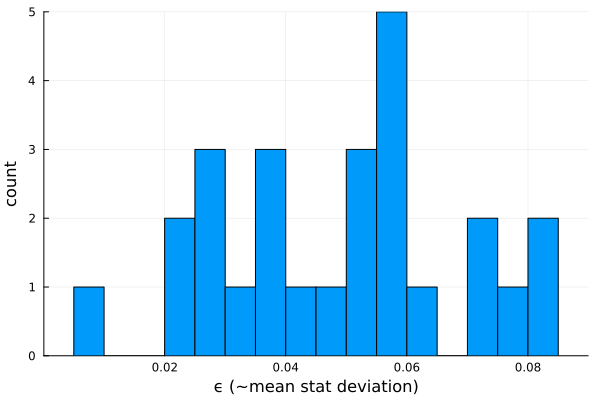

In [15]:
histogram(collect(values(min_dist)), legend=false, xlabel="ϵ (~mean stat deviation)", ylabel="count"; bins=20)

# Plot Simulation of Single Particle

In [16]:
animal_num = 20
idx = best_sample_idx[animal_num]
iter = best_sample_iter[animal_num]
# iter = cvg_idxs[animal_num]

h = load(data_folder * "animal$(animal_num).jls");

ϵ's: [0.235, 0.172, 0.123, 0.096, 0.091, 0.087, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086]
Loss: 0.073
Min/Max loss in iter: (0.073, 0.0963)
Min indices: [3]
Model parameters: [0.99, 19.15, 0.1, 0.22, 0.06, 0.87, 0.81, 0.72, 0.17]
GT stats: [4.0, 50.0, 1.01, 2.19, 3.33, 0.53]
Model stats: [4.0, 54.0, 2.0, 3.0, 3.0, 0.4341085271317829]
Element-wise loss: [0.0, 0.133, 0.396, 0.324, 0.147], avg: 0.2000160672660673


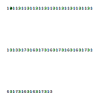

In [17]:
θ = [round(x; digits=2) for x in h.θ[iter][idx]]
gt = [round(x; digits=2) for x in h.x₀]

animal_group, stats_fn = get_stats_fn(animal_num, h)

sample_trajectory = h.x[iter][idx]
model_stats = [round(x; digits=2) for x in stats_fn(sample_trajectory)]
argmins = ([i for (i, x) in enumerate(h.d[iter]) if x == minimum(h.d[iter])])
d_check, norm_check, l_check = distance_verbose(stats_fn(sample_trajectory), gt, animal_group)

println("ϵ's: $([round(x; digits=3) for x in h.ϵ_used])")
println("Loss: $(round(h.d[iter][idx]; digits=4))")
println("Min/Max loss in iter: $((round(minimum(h.d[iter]); digits=4), round(maximum(h.d[iter]); digits=4)))")
println("Min indices: $(argmins[1:minimum([length(argmins), 10])])")
println("Model parameters: $θ")
println("GT stats: $(gt)")
println("Model stats: $(stats_fn(sample_trajectory))")
println("Element-wise loss: $([round(x; digits=3) for x in l_check]), avg: $d_check")

plot_trajectory(sample_trajectory)

# Unimodal Distributions for this Animal

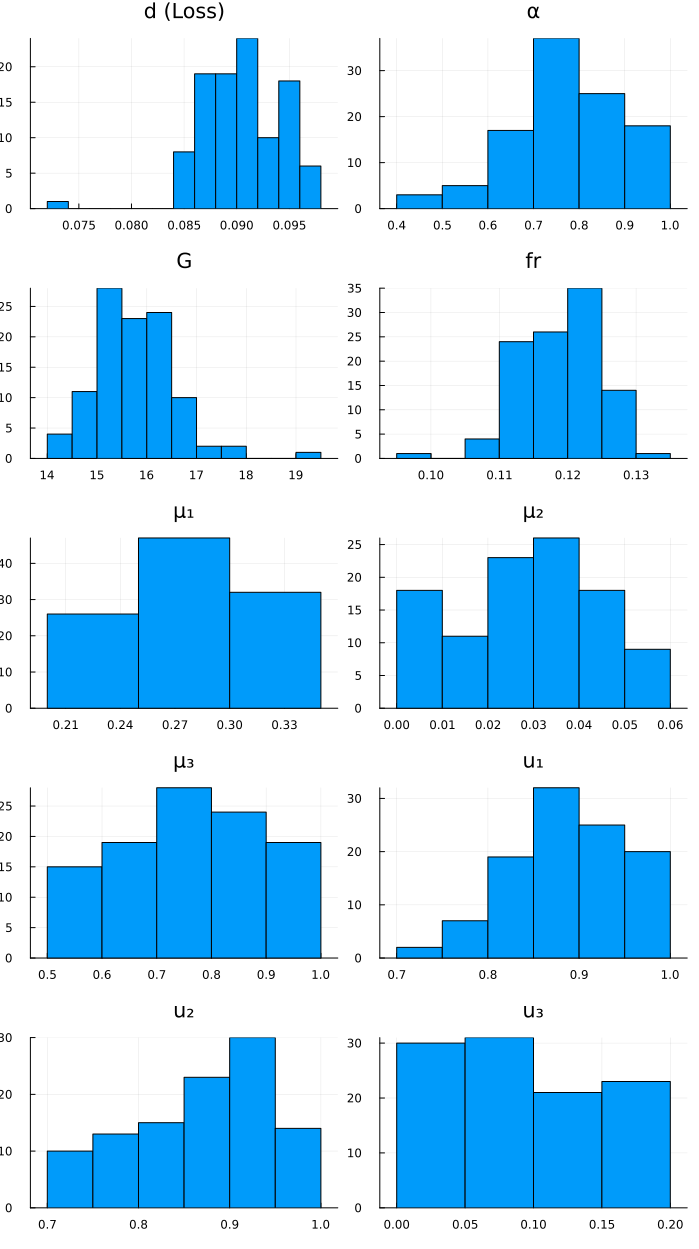

In [18]:
macro Name(arg)
   string(arg)
end

d = h.d[5]
α, G, fr, μ₁, μ₂, μ₃, u₁, u₂, u₃ = [[x[i] for x in h.θ[iter]] for i in range(1, 9)];

plot_list = [
    histogram(d, title="d (Loss)"),
    histogram(α, title=@Name(α)),
    histogram(G, title=@Name(G)),
    histogram(fr, title=@Name(fr)),
    histogram(μ₁, title=@Name(μ₁)),
    histogram(μ₂, title=@Name(μ₂)),
    histogram(μ₃, title=@Name(μ₃)),
    histogram(u₁, title=@Name(u₁)),
    histogram(u₂, title=@Name(u₂)),    
    histogram(u₃, title=@Name(u₃)),    
]

if mod(length(plot_list), 2) == 1
    push!(plot_list, plot_list[end]) 
end

plot(plot_list..., layout=(length(plot_list)÷2, 2), legend=false)
plot!(size=(700, 250*(length(plot_list)÷2)))

# Bivariate Scatter Plots for this Animal

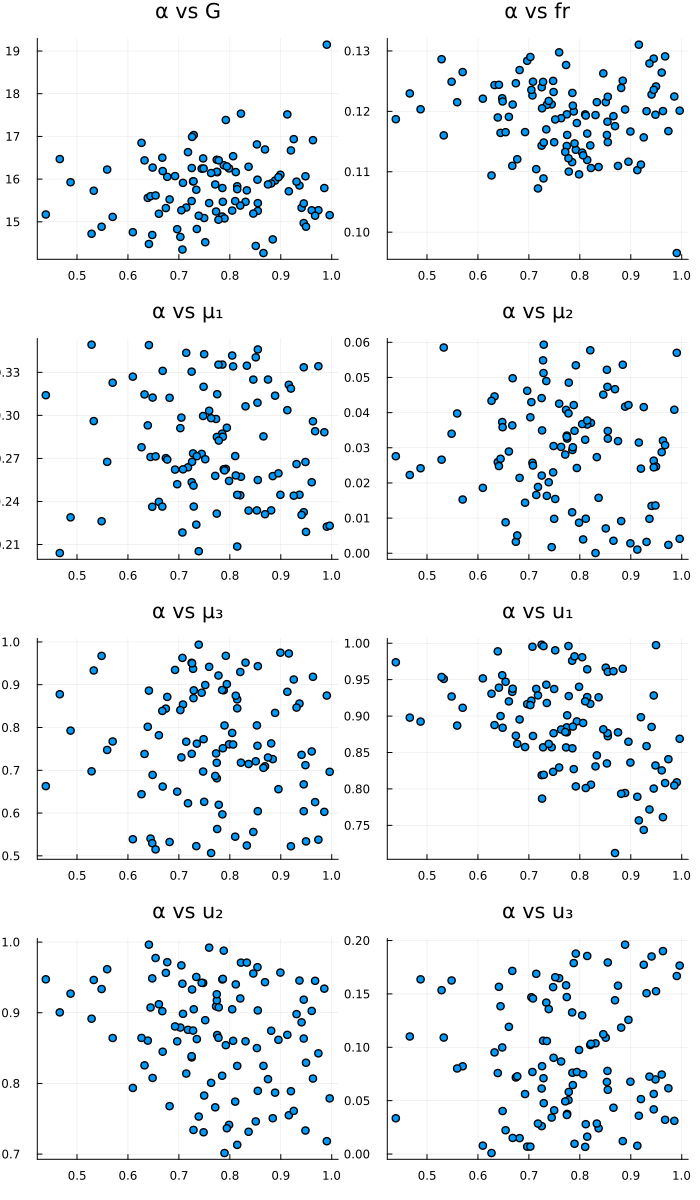

In [19]:
plot_list = [
    scatter(α, G, legend=false, title="α vs G"),
    scatter(α, fr, legend=false, title="α vs fr"),
    scatter(α, μ₁, legend=false, title="α vs μ₁"),
    scatter(α, μ₂, legend=false, title="α vs μ₂"),
    scatter(α, μ₃, legend=false, title="α vs μ₃"),
    scatter(α, u₁, legend=false, title="α vs u₁"),
    scatter(α, u₂, legend=false, title="α vs u₂"),
    scatter(α, u₃, legend=false, title="α vs u₃"),
]

if mod(length(plot_list), 2) == 1
    push!(plot_list, plot_list[end]) 
end

plot(plot_list..., layout=(length(plot_list)÷2, 2), legend=false)
plot!(size=(700, 300*(length(plot_list)÷2)))

# Histogram of Fitted Parameter Means across Animals

In [20]:
sorted_idx = [18, 13, 8, 25, 21, 9, 4, 2, 10, 11, 16, 6, 19, 15, 22, 23, 3, 24, 17, 20, 1, 12, 5, 7, 0, 14];

In [21]:
d_values = []
cvar_values = []
g_values = []
f_values = []
prior_μ1 = []
prior_μ2 = []
prior_μ3 = []
prior_u1 = []
prior_u2 = []
prior_u3 = []

for i in sorted_idx
    fname =  data_folder*"animal$(i).jls"
    if !isfile(fname)
        println("Skipping animal $(i)...")
        continue
    end
    h = load(fname)
    idx = cvg_idxs[i]
    
    if i == 24
       idx = 7 
    end

    push!(d_values, h.d[idx])
    push!(cvar_values, [x[1] for x in h.θ[idx]])
    push!(g_values, [x[2] for x in h.θ[idx]])
    push!(f_values, [x[3] for x in h.θ[idx]])
    push!(prior_μ1, [x[4] for x in h.θ[idx]])
    push!(prior_μ2, [x[5] for x in h.θ[idx]])
    push!(prior_μ3, [x[6] for x in h.θ[idx]])
    push!(prior_u1, [x[7] for x in h.θ[idx]])
    push!(prior_u2, [x[8] for x in h.θ[idx]])
    push!(prior_u3, [x[9] for x in h.θ[idx]])
end

d_mean = [mean(x) for x in d_values]
d_std = [std(x) for x in d_values]
cvar_mean = [mean(x) for x in cvar_values]
cvar_std = [std(x) for x in cvar_values]
g_mean = [mean(x) for x in g_values]
g_std = [std(x) for x in g_values]
f_mean = [mean(x) for x in f_values]
f_std = [std(x) for x in f_values]
prior_μ1_mean = [mean(x) for x in prior_μ1]
prior_μ1_std = [std(x) for x in prior_μ1]
prior_μ2_mean = [mean(x) for x in prior_μ2]
prior_μ2_std = [std(x) for x in prior_μ2]
prior_μ3_mean = [mean(x) for x in prior_μ3]
prior_μ3_std = [std(x) for x in prior_μ3]
prior_u1_mean = [mean(x) for x in prior_u1]
prior_u1_std = [std(x) for x in prior_u1]
prior_u2_mean = [mean(x) for x in prior_u2]
prior_u2_std = [std(x) for x in prior_u2]
prior_u3_mean = [mean(x) for x in prior_u3]
prior_u3_std = [std(x) for x in prior_u3];

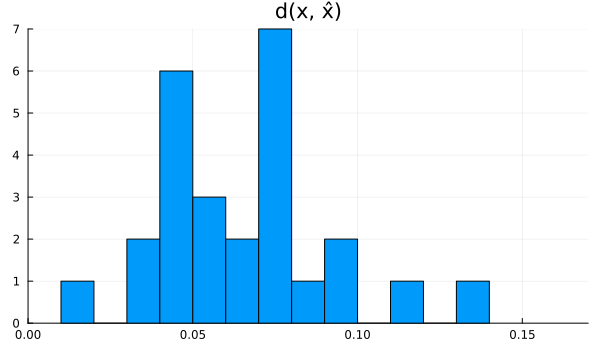

In [22]:
histogram(d_mean, title="d(x, x̂)", xlims=(0.0, 0.17), legend=false; bins=15)
plot!(size=(600, 350))

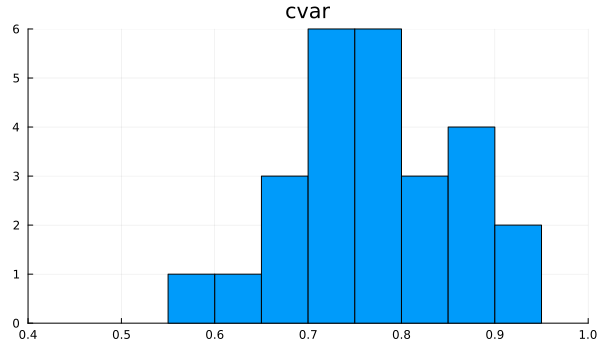

In [23]:
histogram(cvar_mean, title="cvar", xlims=(0.4, 1.0), legend=false; bins=15)
plot!(size=(600, 350))

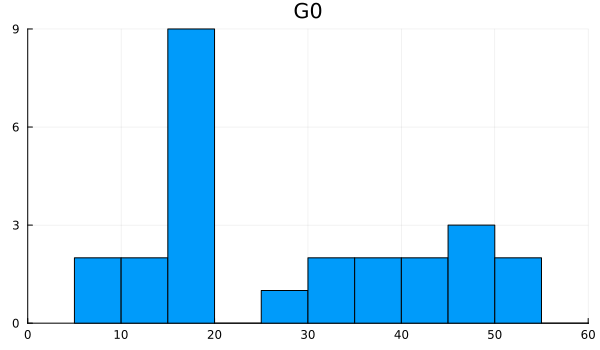

In [24]:
histogram(g_mean, title="G0", xlims=(0, 60), legend=false; bins=15)
plot!(size=(600, 350))

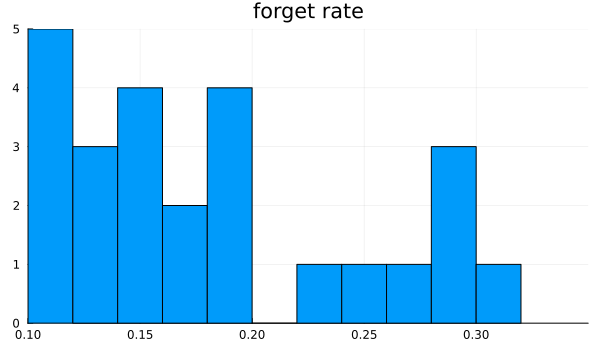

In [25]:
histogram(f_mean, title="forget rate", xlims=(0.1, 0.35), legend=false; bins=20)
plot!(size=(600, 350))

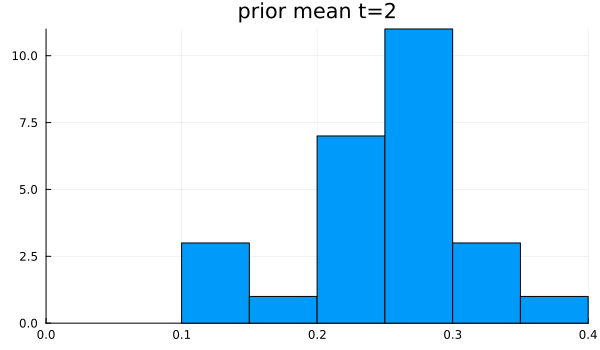

In [26]:
histogram(prior_μ1_mean, title="prior mean t=2", xlims=(0.0, 0.4), legend=false; bins=10)
plot!(size=(600, 350))

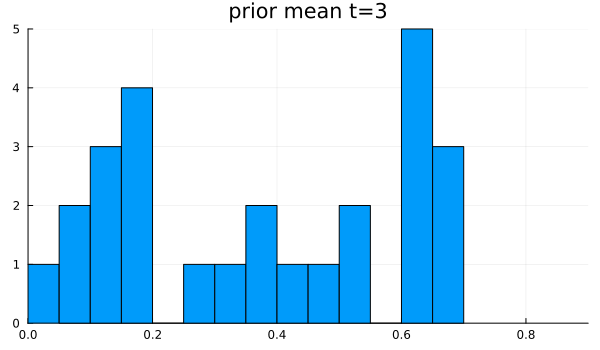

In [27]:
histogram(prior_μ2_mean, title="prior mean t=3", xlims=(0.0, 0.9), legend=false; bins=15)
plot!(size=(600, 350))

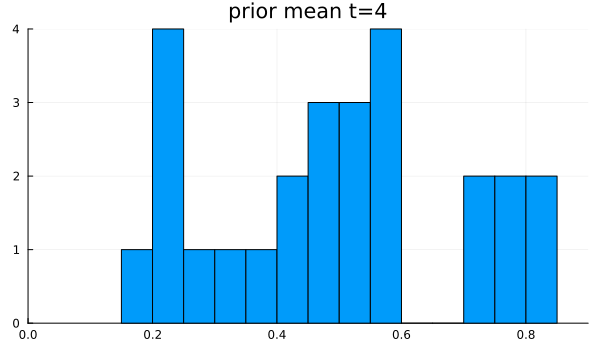

In [28]:
histogram(prior_μ3_mean, title="prior mean t=4", xlims=(0.0, 0.9), legend=false; bins=15)
plot!(size=(600, 350))

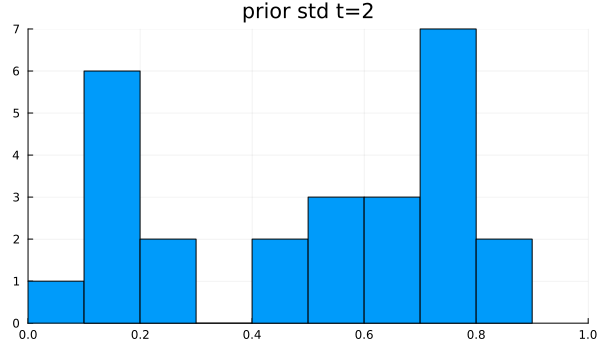

In [29]:
histogram(prior_u1_mean, title="prior std t=2", xlims=(0.0, 1.0), legend=false; bins=10)
plot!(size=(600, 350))

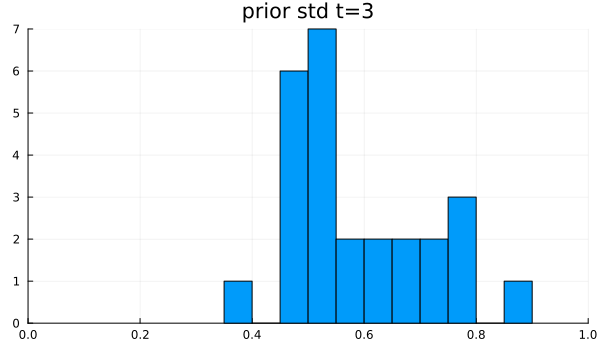

In [30]:
histogram(prior_u2_mean, title="prior std t=3", xlims=(0.0, 1.0), legend=false; bins=10)
plot!(size=(600, 350))

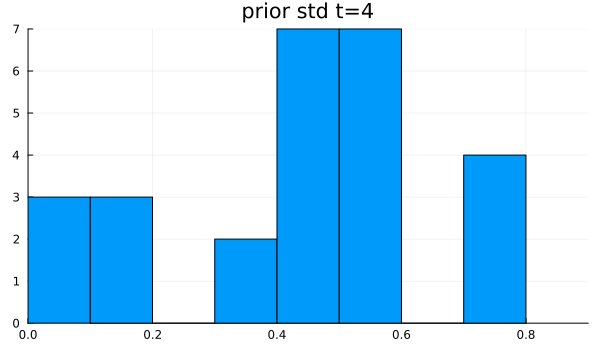

In [31]:
histogram(prior_u3_mean, title="prior std t=4", xlims=(0.0, 0.9), legend=false; bins=10)
plot!(size=(600, 350))